In [4]:
import csv
import os
import random
import pandas as pd
import numpy as np
import umap
import matplotlib.pyplot as plt
#import logomaker
from collections import Counter
import itertools
import seaborn as sns

random_state = 42

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix


In [5]:
# Define the directory path and file names
directory_path = ''
train_file = 'labelled_fasta.csv'
test_file = 'no_selected_seqs_protein.csv'
train_data = pd.read_csv(directory_path + train_file)
test_data = pd.read_csv(directory_path + test_file)

In [6]:
# Shuffle the DataFrame
shuffled_train = train_data.sample(frac=1, random_state = random_state).reset_index(drop=True)
shuffled_test = test_data.sample(frac=1, random_state = random_state).reset_index(drop=True)
shuffled_train

,ID,Sequence,Label
0,cd6b4946-c879-4163-ab1b-d69e2071f5a9_1,MGSPLLRLIHLILALLVLITGLIMLFNTSNSPYLRLIHFLLAILVL...,1
1,c1c9b221-797e-40ab-b243-e18df45778e4;463d37b2-...,MGSPWLRLLHLLLAILVLITGLIMLLNTSNSPYLRLIHFLLALLVL...,0
2,fef64076-dfb6-4803-9808-6cb844f8e186;71283cc0-...,MGSPWLRLLHLLLAILVLITGLIMLLNTSNSPYLRLIHFLLALLVL...,0
3,15835b50-6fcc-4242-be0e-a498408b5453_1,MGSPWLRLLHLILALLVLLTGLIMLLNTSNSPYLRLIHFLLAILVL...,1
4,935e9d7c-4d4f-40af-aabd-e2d94ed77580;0515160d-...,MGSPWLRLLHLFLALLVLLTGLIMLLNTSNSPYLRLIHFLLAILVL...,0
...,...,...,...
2171,588dfe1a-c92d-4945-9645-f16ec37410db;4f00ac8f-...,MGSPWLRLLHLILALLVLITGLIMLLNTSNSPYLRLIHFLLAILVL...,0
2172,34671d91-ecca-4d1d-a507-b60098ec2674_1,MGSPWLRLLHLILALLVLITGLIMLLNTSNSPYLRLIHFLLAILVL...,1
2173,db8390fb-2c05-44b5-9ddc-5ad7b618cd65;f777404d-...,MGSPWIRLLHLILAILVLITGLIMLFNTSNSPYLRLIHFLLAILVL...,0
2174,5f9dc2d7-ea1a-46bc-b4ee-a593cb449805;f17fe284-...,MGSPIIRLIHLILAILVLITGLIMLLNTSNSPYLRLIHFLLAILVL...,0


In [7]:
from sklearn.preprocessing import LabelEncoder

# Sample data
sequences_train = shuffled_train['Sequence']
labels_train = shuffled_train['Label']
sequences_test = shuffled_test['sequence']


# One-hot encode the DNA sequences
def one_hot_encode_protein(sequence):
    mapping = {
        'A': [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        'C': [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        'D': [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        'E': [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        'F': [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        'G': [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        'H': [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        'I': [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        'K': [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        'L': [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        'M': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        'N': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        'P': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        'Q': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        'R': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        'S': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        'T': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
        'V': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
        'W': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
        'Y': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
    }
    return np.array([mapping[base] for base in sequence])

In [8]:
# Apply one-hot encoding to all sequences
encoded_train = np.array([one_hot_encode_protein(seq) for seq in sequences_train])
# Flatten the one-hot encoded matrices into 1D vectors
flattened_train= encoded_train.reshape(encoded_train.shape[0], -1)

# Apply one-hot encoding to all sequences
encoded_test = np.array([one_hot_encode_protein(seq) for seq in sequences_test])
# Flatten the one-hot encoded matrices into 1D vectors
flattened_test = encoded_test.reshape(encoded_test.shape[0], -1)

### 1. UMAP plots

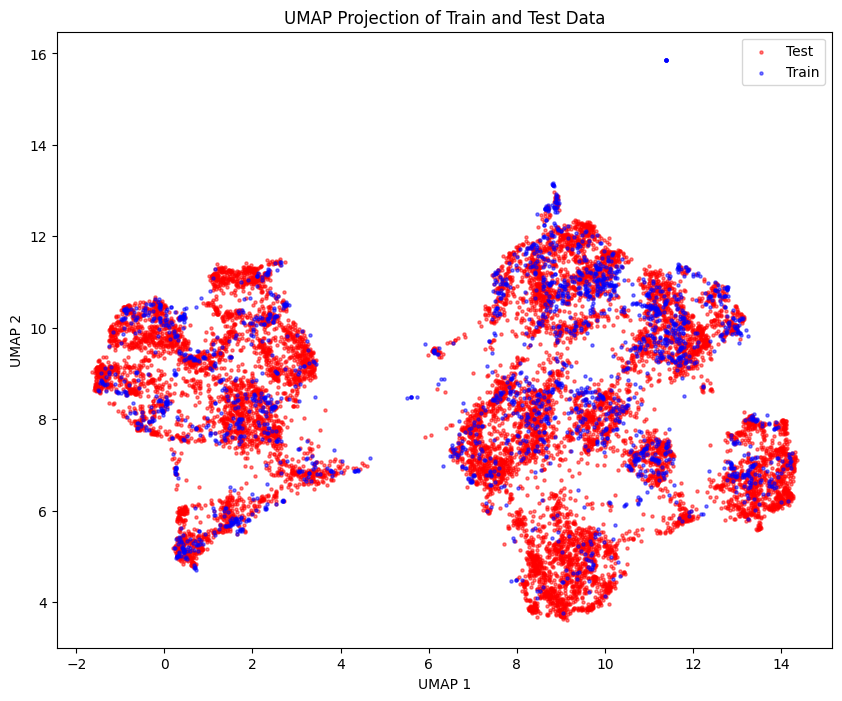

In [9]:
## Combining the datasets and do the UMAP

# Combine the datasets
combined_data = np.vstack((flattened_train, flattened_test))

# Create labels
labels = np.array([0] * len(flattened_train) + [1] * len(flattened_test))

# Fit UMAP
reducer = umap.UMAP()
embedding = reducer.fit_transform(combined_data)

# Plot the results
plt.figure(figsize=(10, 8))
plt.scatter(embedding[labels == 1, 0], embedding[labels == 1, 1], c='red', label='Test', alpha=0.5, s=5)
plt.scatter(embedding[labels == 0, 0], embedding[labels == 0, 1], c='blue', label='Train', alpha=0.5,s=5)

plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.title('UMAP Projection of Train and Test Data')
plt.legend()
plt.show()

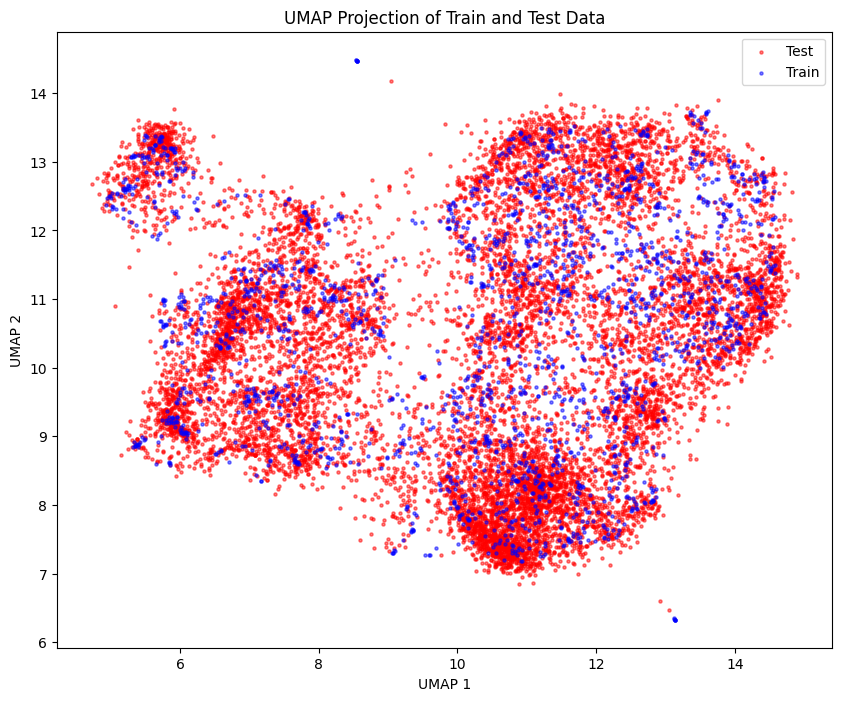

In [10]:
## Train the umap on the train data and project the test data

reducer = umap.UMAP()
train_embedding = reducer.fit_transform(flattened_train)

# Project the test data using the same UMAP model
test_embedding = reducer.transform(flattened_test)

# Plot the results
plt.figure(figsize=(10, 8))
plt.scatter(test_embedding[:, 0], test_embedding[:, 1], c='red', label='Test', alpha=0.5, s=5)
plt.scatter(train_embedding[:, 0], train_embedding[:, 1], c='blue', label='Train', alpha=0.5, s=5)
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.title('UMAP Projection of Train and Test Data')
plt.legend()
plt.show()

### 2. k-fold models and voting

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Load dataset 
X, y = flattened_train, labels_train

# Define preprocessing steps
preprocessing = StandardScaler()

# Define the model 
model = RandomForestClassifier(random_state=42)

# Create a pipeline with preprocessing and model
pipeline = Pipeline([
    ('preprocessing', preprocessing),
    ('classifier', model)
])

# Set up 5-fold cross-validation
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=12)

# Initialize lists to store pipelines and confusion matrices
pipelines = []
conf_matrices = []

# Perform 5-fold cross-validation
for train_index, test_index in kf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    # Train the model using the training set
    pipeline.fit(X_train, y_train)
    
    # Record the trained pipeline
    pipelines.append(pipeline)
    
    # Evaluate the model using the test set
    y_pred = pipeline.predict(X_test)
    
    # Generate confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred)
    conf_matrices.append(conf_matrix)
    
    # Print classification report for each fold
    report = classification_report(y_test, y_pred)
    print(report)


              precision    recall  f1-score   support

           0       0.92      0.91      0.92       211
           1       0.92      0.93      0.92       225

    accuracy                           0.92       436
   macro avg       0.92      0.92      0.92       436
weighted avg       0.92      0.92      0.92       436

              precision    recall  f1-score   support

           0       0.89      0.91      0.90       210
           1       0.91      0.89      0.90       225

    accuracy                           0.90       435
   macro avg       0.90      0.90      0.90       435
weighted avg       0.90      0.90      0.90       435

              precision    recall  f1-score   support

           0       0.93      0.88      0.91       211
           1       0.89      0.94      0.92       224

    accuracy                           0.91       435
   macro avg       0.91      0.91      0.91       435
weighted avg       0.91      0.91      0.91       435

              preci

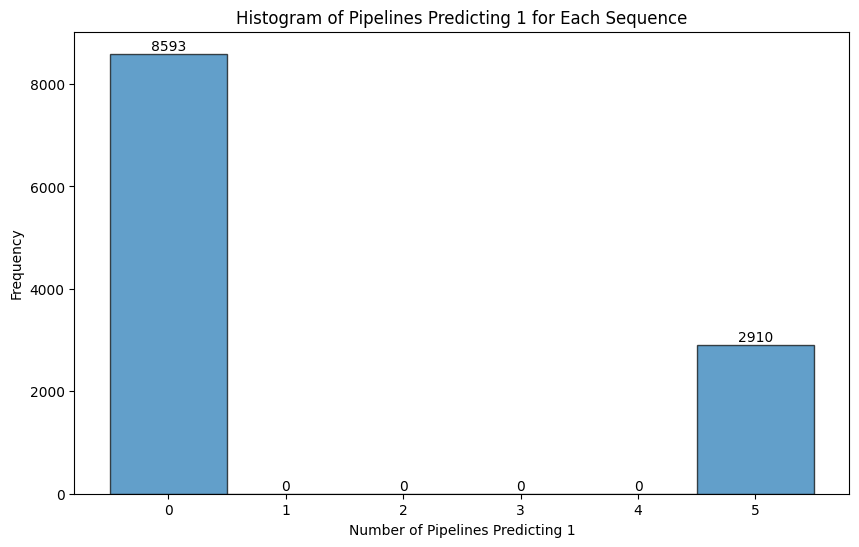

In [12]:
# Collect predictions from each pipeline
predictions = np.array([pipeline.predict(flattened_test) for pipeline in pipelines])

# Sum the predictions across all pipelines for each sequence
count_of_ones = np.sum(predictions,axis=0)

# Plot histogram
plt.figure(figsize=(10, 6))
counts, bins, patches = plt.hist(count_of_ones, bins=np.arange(0, len(pipelines) + 2) - 0.5, edgecolor='black', alpha=0.7)
plt.xlabel('Number of Pipelines Predicting 1')
plt.ylabel('Frequency')
plt.title('Histogram of Pipelines Predicting 1 for Each Sequence')
plt.xticks(np.arange(0, len(pipelines) + 1))

# Add labels on top of the bars
for count, bin in zip(counts, bins):
    plt.text(bin + 0.5, count, str(int(count)), ha='center', va='bottom')

plt.show()

              precision    recall  f1-score   support

           0       0.90      0.91      0.90       211
           1       0.91      0.90      0.91       225

    accuracy                           0.91       436
   macro avg       0.91      0.91      0.91       436
weighted avg       0.91      0.91      0.91       436



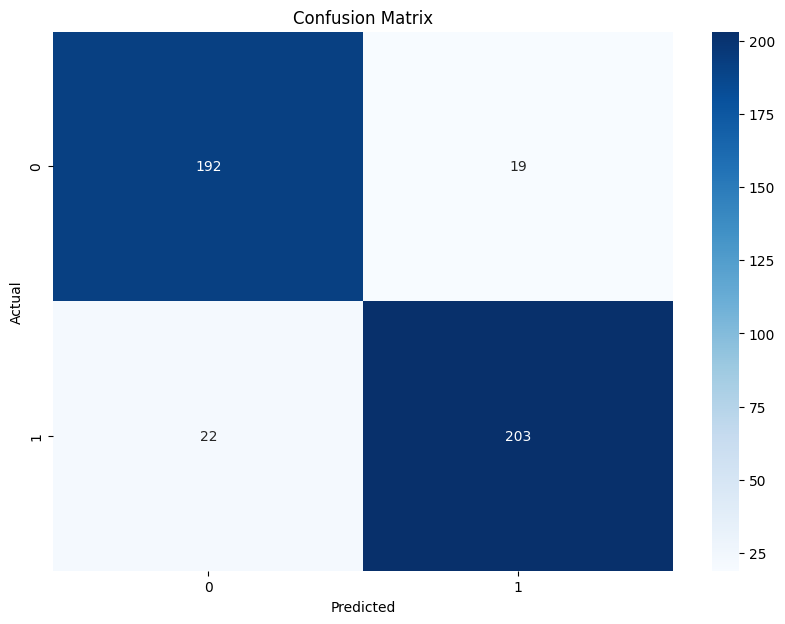

In [13]:
# Load dataset
X, y = flattened_train, labels_train

# Split dataset into train and test sets with stratification
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2, stratify=y, random_state=2)


# Define preprocessing steps
preprocessing = StandardScaler()

# Define the model (choose either MLP or RF)

# model = MLPClassifier(random_state=42)
model = RandomForestClassifier(random_state=42)

# Create a pipeline with preprocessing and model
pipeline = Pipeline([
    ('preprocessing', preprocessing),
    ('classifier', model)
])

# Train the model using the training set
pipeline.fit(X_train, y_train)

# Evaluate the model using the test set
y_pred = pipeline.predict(X_test)
# Generate classification report
report = classification_report(y_test, y_pred)
print(report)

# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

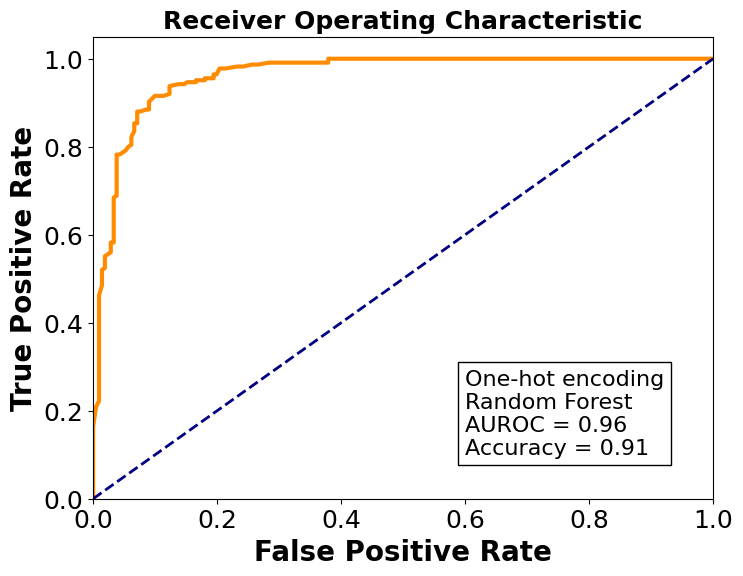

In [14]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
import numpy as np
y_pred_proba = pipeline.predict_proba(X_test)[:, 1]
# y_test contains the true labels and y_pred_proba contains the predicted probabilities
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=3, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.tick_params(labelsize=18)
plt.xlabel('False Positive Rate', fontsize=20, weight='bold')
plt.ylabel('True Positive Rate', fontsize=20, weight='bold')
plt.title('Receiver Operating Characteristic', fontsize=18, weight='bold')
#plt.legend(loc="lower right", fontsize=12)
plt.text(0.6, 0.1, 'One-hot encoding' + "\n" 'Random Forest' + "\n" 'AUROC = %0.2f' % roc_auc + "\n" 'Accuracy = 0.91', fontsize=16, bbox=dict(boxstyle="square,pad=0.3", fc="white", ec="black", lw=1))

# Annotate thresholds
#for i, threshold in enumerate(thresholds):
 #   if i % 10 == 0:  # Annotate every 10th threshold for readability
  #      plt.annotate(f'{threshold:.2f}', (fpr[i], tpr[i]), textcoords="offset points", xytext=(0,10), ha='center')

plt.savefig("roc_curve_final.png", dpi=600, bbox_inches='tight')
plt.show()



### 3. get the probabilities of prediction

              precision    recall  f1-score   support

           0       0.90      0.88      0.89       211
           1       0.89      0.91      0.90       225

    accuracy                           0.89       436
   macro avg       0.89      0.89      0.89       436
weighted avg       0.89      0.89      0.89       436



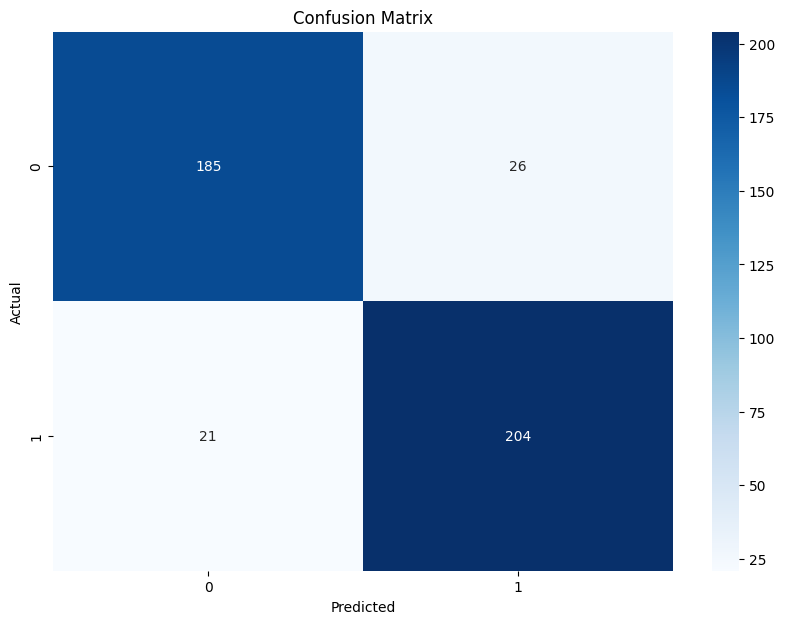

In [15]:
# Load dataset (example using Iris dataset)
X, y = flattened_train, labels_train

# Split dataset into train and test sets with stratification
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2, stratify=y, random_state=244)

# Define preprocessing steps
preprocessing = StandardScaler()

# Define the model (choose either MLP or RF)
# Uncomment the model you want to use
# model = MLPClassifier(random_state=42)
model = RandomForestClassifier(random_state=42)

# Create a pipeline with preprocessing and model
pipeline = Pipeline([
    ('preprocessing', preprocessing),
    ('classifier', model)
])

# Train the model using the training set
pipeline.fit(X_train, y_train)

# Evaluate the model using the test set
y_pred = pipeline.predict(X_test)
# Generate classification report
report = classification_report(y_test, y_pred)
print(report)

# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

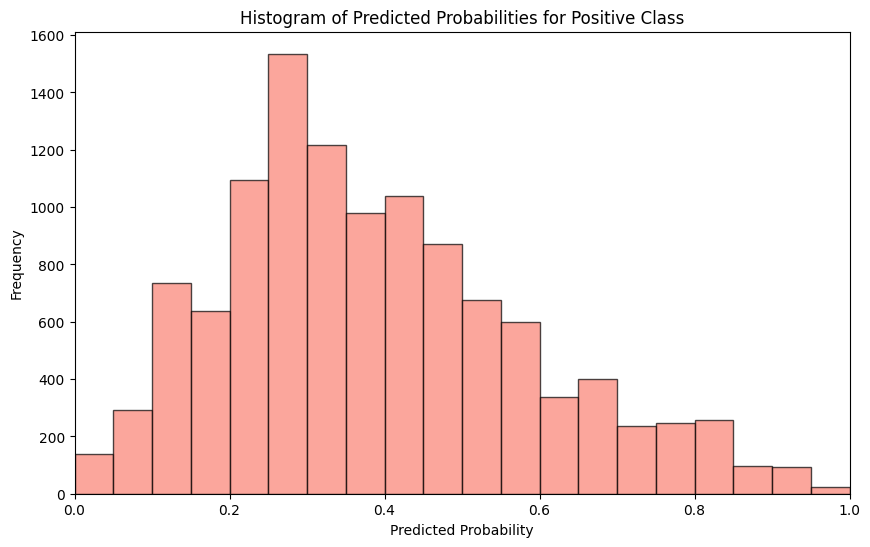

In [16]:
predicted_probabilities = pipeline.predict_proba(flattened_test)
positive_class_probabilities = predicted_probabilities[:, 1]

# Plot histogram
plt.figure(figsize=(10, 6))
counts, bins, patches = plt.hist(positive_class_probabilities, bins=20, range=(0, 1), color="Salmon", edgecolor='black', alpha=0.7)

# Add labels on top of the bars
#for count, bin in zip(counts, bins):
    #plt.text(bin + (bins[1] - bins[0]) / 2, count, str(int(count)), ha='center', va='bottom')

plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')
plt.title('Histogram of Predicted Probabilities for Positive Class')
plt.xlim(0, 1)
plt.show()

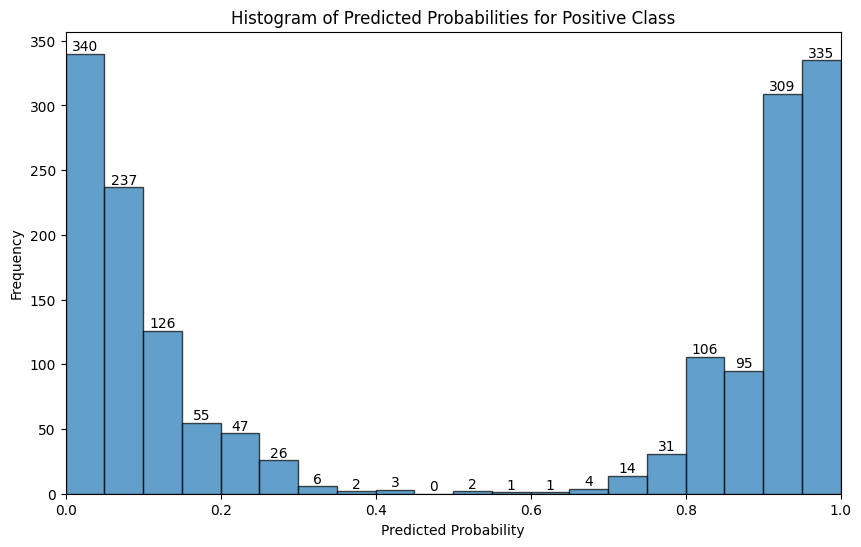

In [17]:
predicted_probabilities = pipeline.predict_proba(X_train)
positive_class_probabilities = predicted_probabilities[:, 1]

# Plot histogram
# Plot histogram
plt.figure(figsize=(10, 6))
counts, bins, patches = plt.hist(positive_class_probabilities, bins=20, range=(0, 1), edgecolor='black', alpha=0.7)

# Add labels on top of the bars
for count, bin in zip(counts, bins):
    plt.text(bin + (bins[1] - bins[0]) / 2, count, str(int(count)), ha='center', va='bottom')

plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')
plt.title('Histogram of Predicted Probabilities for Positive Class')
plt.xlim(0, 1)
plt.show()

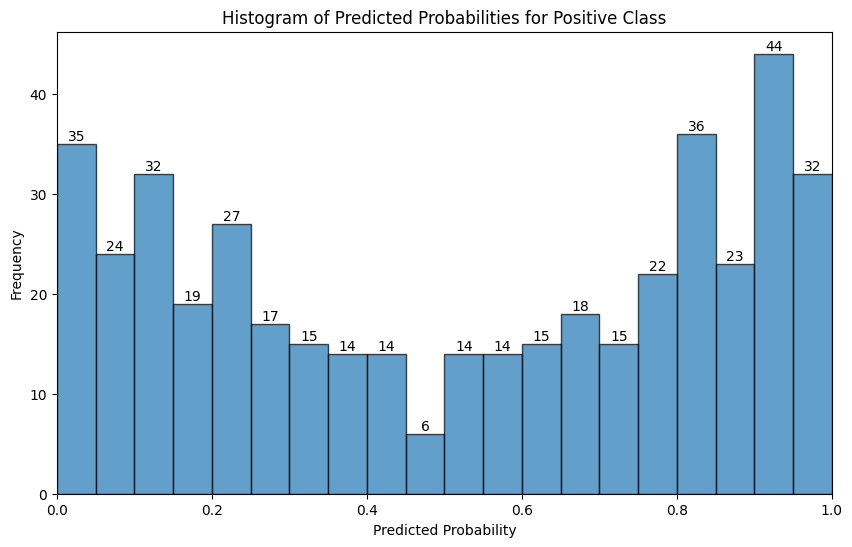

In [18]:
predicted_probabilities = pipeline.predict_proba(X_test)
positive_class_probabilities = predicted_probabilities[:, 1]

# Plot histogram
plt.figure(figsize=(10, 6))
counts, bins, patches = plt.hist(positive_class_probabilities, bins=20, range=(0, 1), edgecolor='black', alpha=0.7)

# Add labels on top of the bars
for count, bin in zip(counts, bins):
    plt.text(bin + (bins[1] - bins[0]) / 2, count, str(int(count)), ha='center', va='bottom')

plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')
plt.title('Histogram of Predicted Probabilities for Positive Class')
plt.xlim(0, 1)
plt.show()

### 4. Save predictions

In [19]:
# Load training dataset
X, y = flattened_train, labels_train

# Split dataset into train and test sets with stratification
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2, stratify=y, random_state=244)

# Define preprocessing steps
preprocessing = StandardScaler()

# Define the model (choose either MLP or RF)
# model = MLPClassifier(random_state=42)
model = RandomForestClassifier(random_state=42)

# Create a pipeline with preprocessing and model
pipeline = Pipeline([
    ('preprocessing', preprocessing),
    ('classifier', model)
])

# Train the model using the training set
pipeline.fit(X_train, y_train)

# Evaluate the model using the test set
y_pred = pipeline.predict(X_test)
# Generate classification report on test set
report = classification_report(y_test, y_pred)
print(report)



              precision    recall  f1-score   support

           0       0.90      0.88      0.89       211
           1       0.89      0.91      0.90       225

    accuracy                           0.89       436
   macro avg       0.89      0.89      0.89       436
weighted avg       0.89      0.89      0.89       436



In [20]:
# prediction on unknown dataset
# predicted_probabilities is a 2D array where each of the 2 rows contains the probabilities for each class. e.g. [0.4, 0.6] for a sequence means 40% for class 0 (dim) and 60% for class 1 (bright)
predicted_probabilities = pipeline.predict_proba(flattened_test)

# Take the probabilities for the positive class (bright) as the label
positive_class_probabilities = predicted_probabilities[:, 1]
shuffled_test['Label'] = positive_class_probabilities

In [21]:
shuffled_test.head()

,sequence,Label
0,MGSPWLRLLHLILAILVLITGLIMLLNTSNSPYLRLIHFLLAVLVI...,0.64
1,MGSPWLRLLHLILALLVLITGLIMLLNTSNSPYLRLIHFLLAILVL...,0.29
2,MGSPILRLIHLFLALLVLLTGLIMLLNTSNSPYLRLIHFLLAILVL...,0.31
3,MGSPWLRLLHLILALLVLITGLIMLLNTSNSPYLRLIHFLLAILVL...,0.82
4,MGSPWLRLLHLILALLVLITGLIMLLNTSNSPYLRLIHFLLAILVL...,0.28


In [22]:
shuffled_test_sorted = shuffled_test.sort_values(by='Label', ascending=False)
shuffled_test_sorted.head()

,sequence,Label
4175,MGSPLLRLIHLILALLVLLTGLIMLLNTSNSPYLRLIHFLLAILVL...,0.99
5276,MGSPWLRLLHLILALLVLLTGLIMLLNTSNSPYLRLIHFLLAILVL...,0.99
6558,MGSPWLRLLHLILAILVFITGLIMLLNTSNSPYLRLIHFLLAILVL...,0.98
9656,MGSPWLRLLHLILALLVLITGLIMLLNTSNSPYLRLIHFLLAILVL...,0.98
8968,MGSPWLRLLHLILALLVLITGLIMLLNTSNSPYLRLIHFLLAILVL...,0.98


In [23]:
encoded_sort= np.array([one_hot_encode_protein(seq) for seq in shuffled_test_sorted['sequence']])
# Flatten the one-hot encoded matrices into 1D vectors
flattened_sort = encoded_sort.reshape(encoded_sort.shape[0], -1)

In [24]:
predicted_probabilities = pipeline.predict_proba(flattened_sort)
predicted_probabilities 

array([[0.01, 0.99],
       [0.01, 0.99],
       [0.02, 0.98],
       ...,
       [1.  , 0.  ],
       [1.  , 0.  ],
       [1.  , 0.  ]])

In [25]:
# evaluate one new sequence
new_seq = "MGSPFLRLIHLILALLVLLTGLIMLLNTSNSPYLRLIHFLLAILVLITGLIMLKNGSRSPSPILRLLHLILAILVFLTGLIMLWNTSNSPYLRLIHFLLALLVFLTGFLMLNQ"
predicted_probability = pipeline.predict_proba(one_hot_encode_protein(new_seq).flatten().reshape(1, -1))
predicted_probability

array([[0.56, 0.44]])

In [26]:
#save as csv
shuffled_test_sorted.to_csv('predicted_protein.csv', index=False)

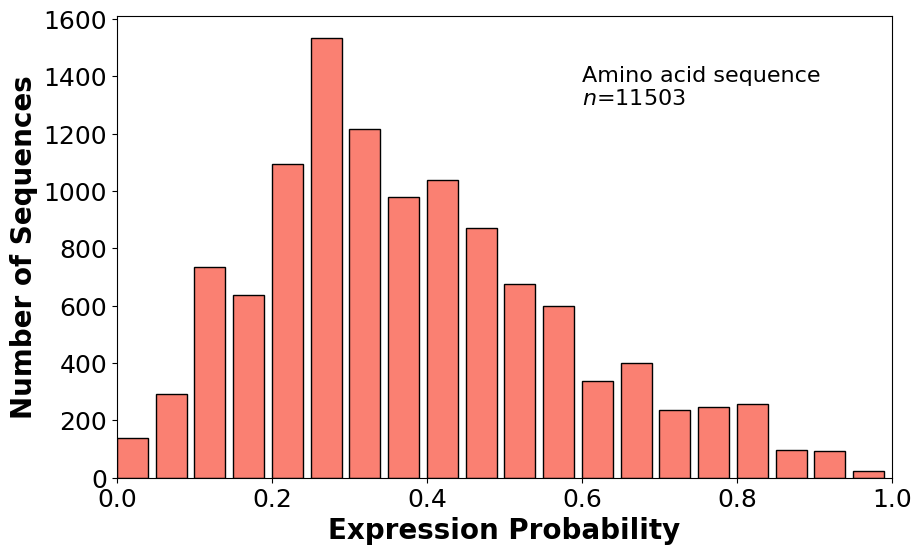

In [27]:
predicted_probabilities = pipeline.predict_proba(flattened_test)
positive_class_probabilities = predicted_probabilities[:, 1]

# Plot histogram
plt.figure(figsize=(10, 6))
counts, bins, patches = plt.hist(positive_class_probabilities, bins=20, range=(0, 1), color="Salmon", edgecolor='black', alpha=1, width=0.04)

# Add labels on top of the bars
#for count, bin in zip(counts, bins):
#    plt.text(bin + (bins[1] - bins[0]) / 2, count, str(int(count)), ha='center', va='bottom')

plt.xlabel('Expression Probability', fontsize=20, weight='bold')
plt.ylabel('Number of Sequences', fontsize=20, weight='bold')
plt.tick_params(labelsize=18)
#plt.title('Histogram of Predicted Probabilities for Positive Class')
plt.xlim(0, 1)
plt.text(0.6, 1300, 'Amino acid sequence' + "\n" '$\it{n}$=11503', fontsize=16, bbox=dict(boxstyle="square,pad=0.3", fc="white", ec="black", lw=0))
plt.savefig("prediction_histogram.png", dpi=600, bbox_inches='tight')
plt.show()

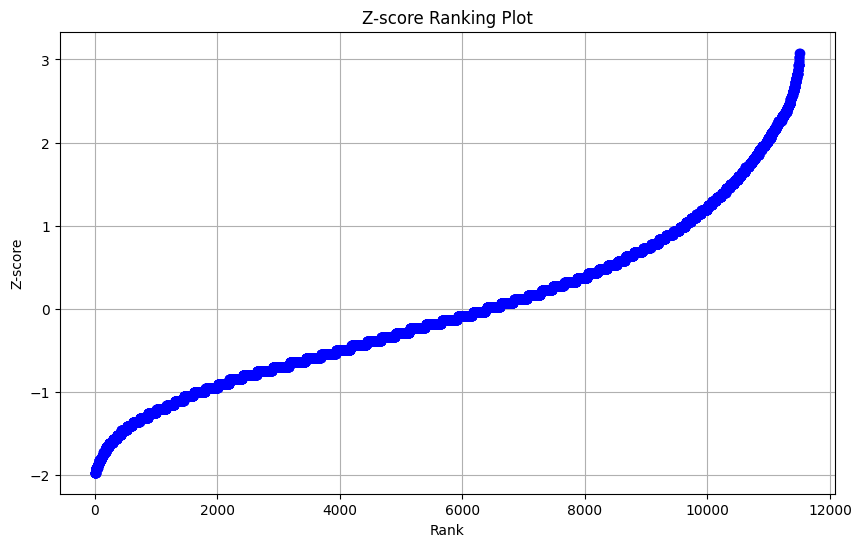

In [28]:
from scipy.stats import zscore
import numpy as np
import matplotlib.pyplot as plt

# Calculate z-scores
predicted_probabilities = pipeline.predict_proba(flattened_test)
positive_class_probabilities = predicted_probabilities[:, 1]
positive_class_probabilities_array = np.array(positive_class_probabilities)
z_scores = zscore(positive_class_probabilities_array)

# Sort z-scores
sorted_z_scores = np.sort(z_scores)

# Calculate ranks
ranks = np.arange(1, len(sorted_z_scores) + 1)

# Plot z-score ranking
plt.figure(figsize=(10, 6))
plt.plot(ranks, sorted_z_scores, marker='o', linestyle='-', color='b')

plt.xlabel('Rank')
plt.ylabel('Z-score')
plt.title('Z-score Ranking Plot')
plt.grid(True)
plt.show()

### 5. Umap of all the predicted results

In [29]:
sequences_train = shuffled_train['Sequence']
labels_train = shuffled_train['Label']
sequences_test = shuffled_test['sequence']
labels_test = shuffled_test['Label']

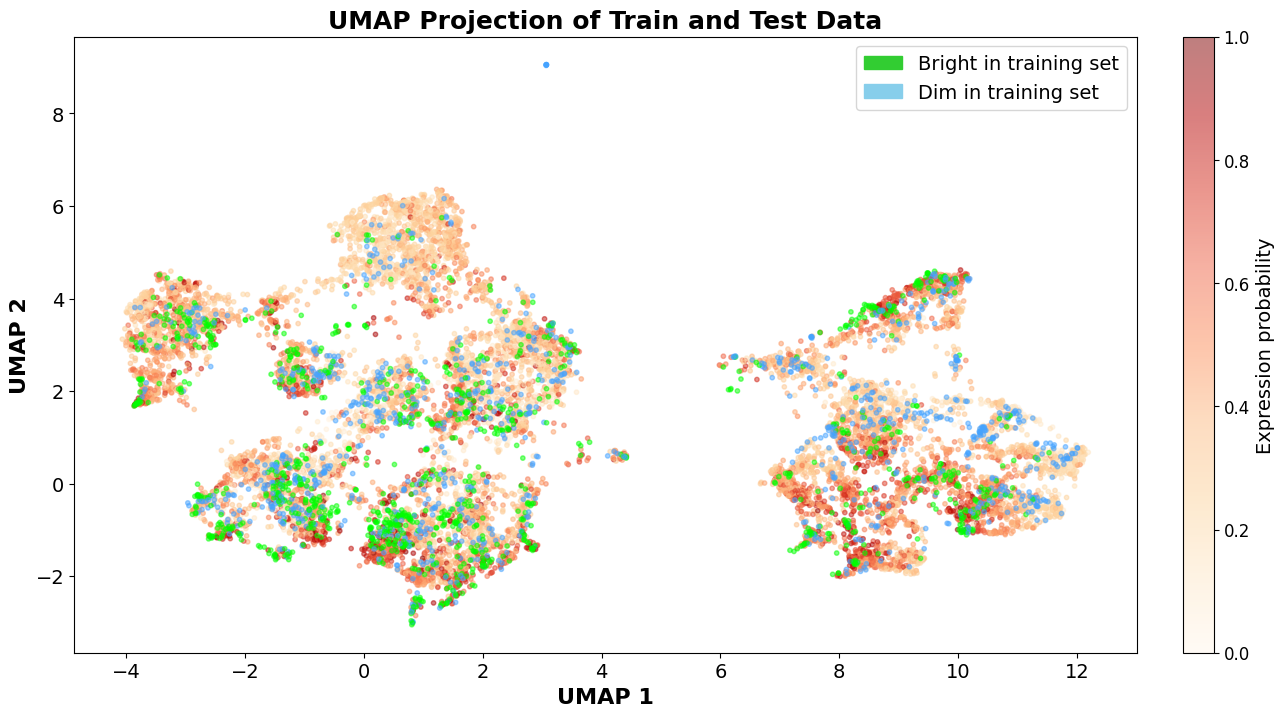

In [30]:
import numpy as np
import umap
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.patches as mpatches

# Define a custom colormap from skyblue to green as per Prism colours
colors = [(0.27, 0.64, 1), (0, 1, 0)]  # blue -> green
n_bins = 100  # Discretizes the interpolation into bins
cmap_name = 'blue_green_cmap'
blue_green_cmap = LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bins)

# Define a custom colormap from green to red
colors = [(0, 1, 0), (1, 0, 0)]  # Green -> Red
cmap_name = 'green_red_cmap'
green_red_cmap = LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bins)

# Step 1: Combine the data
combined_data = np.vstack((flattened_train, flattened_test))

# Step 2: Create labels for the combined data
labels = np.array([0] * len(flattened_train) + [1] * len(flattened_test))

# Step 3: Fit UMAP
reducer = umap.UMAP()
embedding = reducer.fit_transform(combined_data)

# Step 4: Extract the embeddings for train and test data separately
embedding_train = embedding[labels == 0]
embedding_test = embedding[labels == 1]

# Step 5: Extract the labels for train and test data separately
train_labels = shuffled_train['Label'].values
test_labels = shuffled_test['Label'].values

# Step 6: Create a mask for test labels >= 0.9
#high_confidence_mask = test_labels >= 0.9

# Step 7: Plot the results in the same plot
fig, ax = plt.subplots(figsize=(15, 8))

# Plot for train data
scatter_train = ax.scatter(embedding_train[:, 0], embedding_train[:, 1], c=train_labels, cmap=blue_green_cmap, alpha=0.5, s=10, marker='o', zorder=2, vmin=0, vmax=1)
# cbar_train = fig.colorbar(scatter_train, ax=ax, orientation='vertical', fraction=0.046, pad=0.04)
# cbar_train.set_label('Train Label')

# Plot for test data (excluding high confidence)
#scatter_test = ax.scatter(embedding_test[~high_confidence_mask, 0], embedding_test[~high_confidence_mask, 1], c=test_labels[~high_confidence_mask], cmap='OrRd', alpha=0.5, s=10, marker='o', zorder=1, vmin=0, vmax=1)
scatter_test = ax.scatter(embedding_test[:, 0], embedding_test[:, 1], c=test_labels, cmap='OrRd', alpha=0.5, s=10, marker='o', zorder=1, vmin=0, vmax=1)
cbar_test = fig.colorbar(scatter_test, ax=ax, orientation='vertical', fraction=0.046, pad=0.04)
cbar_test.set_label('Expression probability', fontsize=14)
cbar_test.ax.tick_params(labelsize=12)

# Plot for high confidence test data
#scatter_high_confidence = ax.scatter(embedding_test[high_confidence_mask, 0], embedding_test[high_confidence_mask, 1], c='red', alpha=0.7, s=10, marker='o', zorder=3)

# Add custom legend
bright_patch = mpatches.Patch(color='limegreen', label='Bright in training set')
grey_patch = mpatches.Patch(color='skyblue', label='Dim in training set')
ax.legend(handles=[bright_patch, grey_patch], fontsize=14)

ax.set_xlabel('UMAP 1', fontsize=16, weight='bold')
ax.set_ylabel('UMAP 2', fontsize=16, weight='bold')
ax.set_title('UMAP Projection of Train and Test Data', fontsize=18, weight='bold')
plt.tick_params(labelsize=14)
plt.savefig("umap4_dotsize10_nomask.png", dpi=600, bbox_inches='tight')
plt.show()

In [31]:
len(flattened_test)

11503

In [32]:
import shap

amino_acids = 'ACDEFGHIKLMNPQRSTVWY'

# Create the SHAP explainer for the Random Forest model
explainer = shap.TreeExplainer(model)

# Calculate SHAP values for the test set
shap_values = explainer.shap_values(flattened_test[:1000])


In [33]:
shap_values = np.sum(shap_values[:,:,1], axis=0)
SHAP_importances = shap_values.reshape(113, -1).transpose()

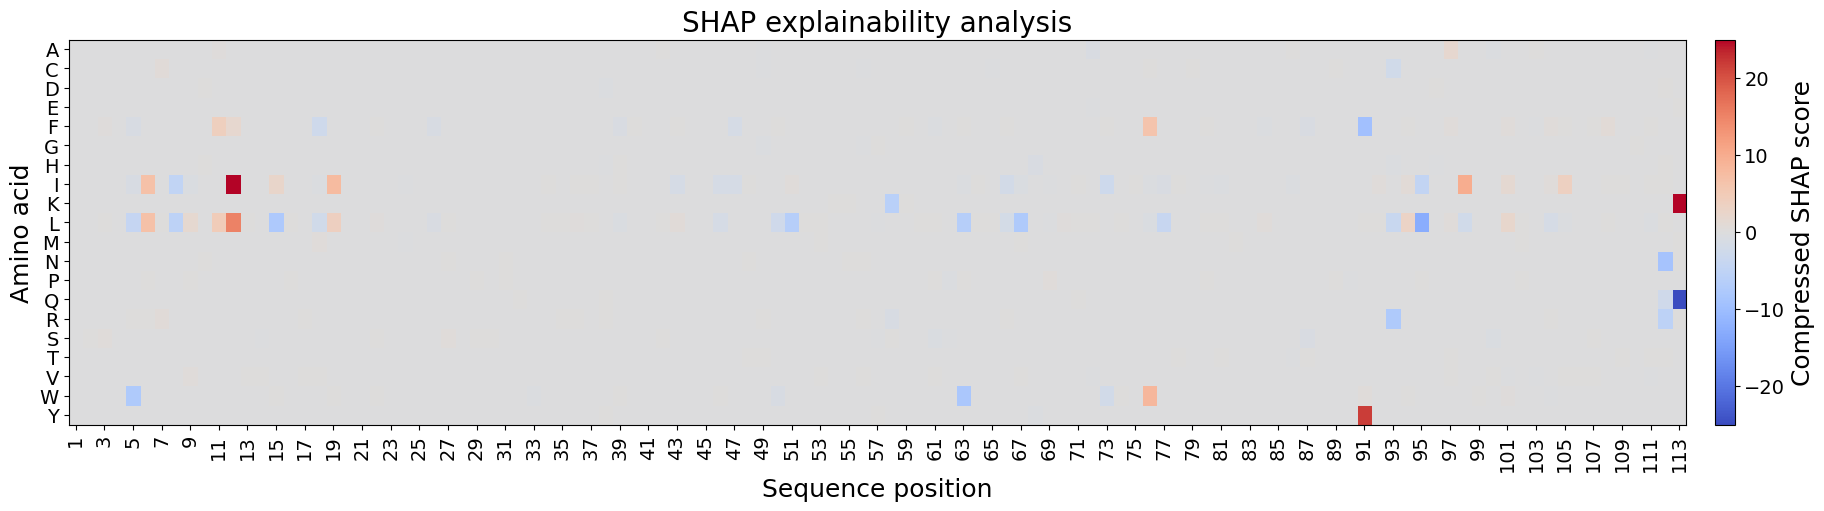

In [34]:
vmin = -max(abs(SHAP_importances.min()), abs(SHAP_importances.max()))
vmax = max(abs(SHAP_importances.min()), abs(SHAP_importances.max()))

plt.figure(figsize=(25, 5))
plt.xticks(np.arange(113), range(1, 114, 1),rotation=90)
plt.yticks(np.arange(20),list(amino_acids))
plt.title('SHAP explainability analysis', fontsize=20)
plt.ylabel('Amino acid', size=18)
plt.xlabel('Sequence position', size=18)
plt.tick_params(axis='y',labelsize=14)
plt.tick_params(axis='x',labelsize=14)
plt.locator_params(nbins=57, axis='x')
#To show more information in the plot, artificially adjust the SHAP range away from vmin=vmin, vmax=vmax; then change print cmd)
plt.imshow(SHAP_importances, aspect='auto', cmap='coolwarm', interpolation='nearest',vmin=-25, vmax=25)
cbar=plt.colorbar(orientation='vertical', pad=0.015)
cbar.set_label('Compressed SHAP score', fontsize=18)
cbar.ax.tick_params(labelsize=14)
plt.savefig("compressed_SHAP_25_25.png", dpi=600, bbox_inches='tight')

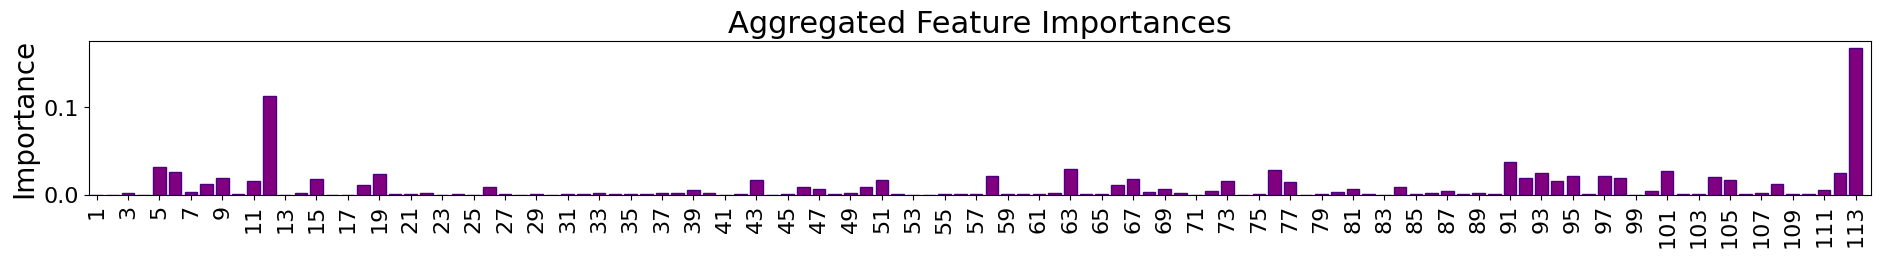

In [35]:
import numpy as np
import matplotlib.pyplot as plt

# Access feature importances from the RandomForestClassifier
feature_importances = model.feature_importances_

# Aggregate feature importances with a step size of 20
step_size = 20
aggregated_AA_importances = [
    sum(feature_importances[i:i + step_size]) for i in range(0, len(feature_importances), step_size)
]

# Generate new feature names for the aggregated features

# Plot aggregated feature importances
plt.figure(figsize=(23, 2))
plt.bar(range(len(aggregated_AA_importances)), aggregated_AA_importances, align='center', color='purple', edgecolor='indigo')
plt.xlim(-0.5, 113)
plt.xticks(np.arange(113), range(1, 114, 1),rotation=90)
plt.tick_params(axis='x',labelsize=16)
plt.locator_params(nbins=57, axis='x')
plt.tick_params(axis='y',labelsize=16)
#plt.xticks(range(0, len(aggregated_AA_importances), 5), range(1, len(aggregated_AA_importances) + 1, 5), rotation=90)
#plt.xlabel('Sequence position', size=18)
plt.ylabel('Importance', size=20)
plt.title('Aggregated Feature Importances', fontsize=22)
plt.savefig("aggregated_importance_scores", dpi=600, bbox_inches='tight')
plt.show()

### 